# ADCP filtering in space & comparison with SWOT/DUACS

Author: Elisabet Verger-Miralles, May 2024


1) ADCP raw for one transect and one depth


2) Filtering ADCP cross-section velocities

    2.1 - compute distance

    2.2 - interpolate to regular grid (in kms)
    
    2.3 - Low-pass filtering in space (distance)

3) Compute cross-section velocities

4) Interpolate SWOT and DUACS to the same transect

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.signal import butter, filtfilt
import math
import cmath
from scipy.interpolate import griddata
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import cmocean
import cartopy.crs           as ccrs
import cartopy.feature       as cfeature
import matplotlib.gridspec   as gridspec

In [2]:
trans = 6
dep = 80

## Functions

In [3]:
# Define a low-pass Butterworth filter
def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist  # cutoff = 1 / [km]
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Digital filter critical frequencies must be 0 < Wn < 1

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth's surface.
    
    Parameters:
    lat1, lon1 -- latitude and longitude of point 1 (in decimal degrees)
    lat2, lon2 -- latitude and longitude of point 2 (in decimal degrees)
    
    Returns:
    distance -- distance between the two points (in kilometers)
    """
    R = 6371.0  # Earth’s radius in kilometers
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance


# ADCP

#### IMPORT DATA 

In [5]:
# dir_adcp = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/'
dir_adcp = '../../SWOT/'
ds = xr.open_dataset(dir_adcp+'ADCP_OS150_FaSt-SWOT_LEG1_V3.nc')

In [6]:
df = ds.to_dataframe().reset_index(drop=False)

In [7]:
lon_adcp = np.array(df.loc[(df.transect_id==trans)& (df.depth==dep),'lon']) # basta a una prof, lon i lat a totes les prof. serà la mateixa
lat_adcp = np.array(df.loc[(df.transect_id==trans)& (df.depth==dep),'lat'])

In [8]:
u_adcp = df.loc[(df.transect_id==trans) & (df.depth==dep),'u']
v_adcp = df.loc[(df.transect_id==trans) & (df.depth==dep),'v']

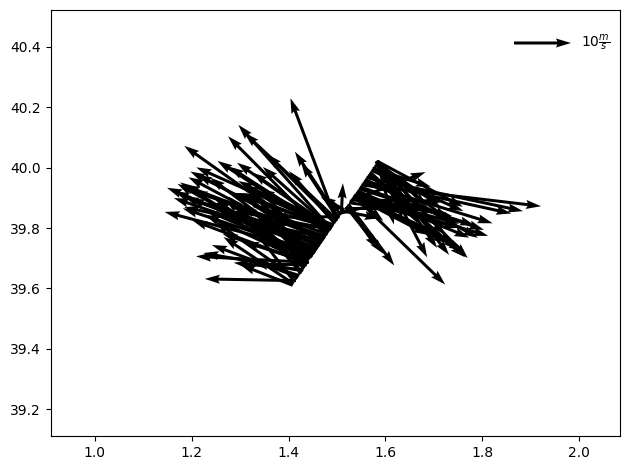

In [9]:
fig1, ax1 = plt.subplots()

# Paint only a few vectors of the quiver
q = plt.quiver(lon_adcp[::2], lat_adcp[::2], u_adcp[::2], v_adcp[::2], scale=1)

# Set x and y limits to tightly fit the data
plt.xlim([lon_adcp.min() - 0.5, lon_adcp.max() + 0.5])
plt.ylim([lat_adcp.min() - 0.5, lat_adcp.max() + 0.5])

# add quiver key
qk = plt.quiverkey(q, 0.9, 0.9, 0.1, r'$10 \frac{m}{s}$', labelpos='E', coordinates='figure')

#dont cut the figure
plt.tight_layout()
plt.show()

### FILTER DATA

In [10]:
# Initialize the first point (start of the transect)
lat0, lon0 = lat_adcp[0], lon_adcp[0]

# Calculate distances from the first point to each point
distances = [haversine(lat0, lon0, lat, lon) for lat, lon in zip(lat_adcp, lon_adcp)]

# Generate regular distance intervals (0.25 km)
max_distance = distances[-1]
regular_distances = np.arange(0, max_distance, 0.25)

# Interpolation function
interpolator = interp1d(distances, list(zip(lat_adcp, lon_adcp)), axis=0, kind='linear')

# Interpolate latitudes and longitudes at regular distances
interpolated_points = interpolator(regular_distances)
interpolated_lats, interpolated_lons = interpolated_points.T

In [11]:
# Filter parameters
cutoff_distance = 0.067 # cutoff frequency in 1/5 km = 0.2, 1/10km = 0.1, 1/0.067 = 15 km
fs = 1 / (regular_distances[1] - regular_distances[0])  # sampling frequency in points per km

In [12]:
regular_distances[1] - regular_distances[0]

0.25

In [13]:
# Interpolation function for velocities
interpolator_u= interp1d(distances, u_adcp, kind='linear')
interpolator_v= interp1d(distances, v_adcp, kind='linear')

# Interpolate velocities at regular distances
interpolated_u = interpolator_u(regular_distances)
interpolated_v = interpolator_v(regular_distances)

# Apply the low-pass filter to the interpolated velocities
u_filtered = low_pass_filter(interpolated_u, cutoff_distance, fs)
v_filtered = low_pass_filter(interpolated_v, cutoff_distance, fs)

### COMPUTE CROSS-SECTION VELOCITIES

In [14]:
# Coordinates of two points of the section (used to compute angle)
if trans == 6: # Transect 6: 1.41, 39.65, 1.58, 40
    lon1=1.41;
    lat1=39.65;
    lon2=1.58;
    lat2=40;

elif trans == 8: 
    lon1=1.73;
    lat1=39.8;
    lon2=1.3;
    lat2=39.9;

elif trans == 10: # REVISAR
    lon1=1.26;
    lat1=39.92;
    lon2=1.68;
    lat2=39.8;

In [15]:
# Compute angle 
# dlon=lon2-lon1;
# dlat=lat2-lat1;
dlon=lon1-lon2;
dlat=lat1-lat2;
mean_lat = math.radians((lat1 + lat2) / 2.0) # in radians
angle=np.rad2deg(np.arctan2(dlat,dlon*math.cos(mean_lat)));   # 0 is West, +90 is North, 180 is East, -90 is South, -180 is East

In [16]:
# Calculate the rotated complex number
uv_rotated = (u_filtered + 1j*v_filtered) * cmath.exp(1j * (-angle) * cmath.pi / 180)
uv_rotated_unfiltered = (u_adcp+ 1j*v_adcp) * cmath.exp(1j * (-angle) * cmath.pi / 180)

# Extract along- and cross-section values
uv_along = uv_rotated.real
uv_cross = np.array(uv_rotated).imag
uv_cross_unfiltered = np.array(uv_rotated_unfiltered).imag

# SWOT

In [17]:
path = '../../SWOT/SWOT_data_L3/v03/expert/'
# path = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/SWOT_data_L3/v03/expert/'
files = glob.glob(path+'*.nc')
files = np.sort(files)
file = files[24]
file

'../../SWOT/SWOT_data_L3/v03/expert/SWOT_L3_LR_SSH_Expert_502_016_20230426T062612_20230426T071717_v0.3.nc'

In [18]:
ds_SWOT = xr.open_dataset(file)

Interpolate SWOT to ADCP transect

In [19]:
lon_min = lon_adcp.min()-0.5
lon_max = lon_adcp.max()+0.5
lat_min = lat_adcp.min()-0.5
lat_max = lat_adcp.max()+0.5
 
# Subselect region first that no nadir dim problems:
# Subregion:
ds_SWOT = ds_SWOT.where(ds_SWOT['longitude'].compute()<lon_max, drop=True)
ds_SWOT = ds_SWOT.where(ds_SWOT['longitude'].compute()>lon_min, drop=True)
ds_SWOT = ds_SWOT.where(ds_SWOT['latitude'].compute()<lat_max, drop=True)
ds_SWOT = ds_SWOT.where(ds_SWOT['latitude'].compute()>lat_min, drop=True)

In [20]:
ssha = ds_SWOT.ssha.values.flatten()[~np.isnan(ds_SWOT.ssha.values.flatten())]
ssha_noiseless = ds_SWOT.ssha_noiseless.values.flatten()[~np.isnan(ds_SWOT.ssha.values.flatten())]
mdt = ds_SWOT.mdt.values.flatten()[~np.isnan(ds_SWOT.ssha.values.flatten())]
dh = ssha_noiseless + mdt

lon_swot = ds_SWOT.longitude.values.flatten()[~np.isnan(ds_SWOT.ugos.values.flatten())]
lat_swot = ds_SWOT.latitude.values.flatten()[~np.isnan(ds_SWOT.ugos.values.flatten())]
u_swot = ds_SWOT.ugos.values.flatten()[~np.isnan(ds_SWOT.ugos.values.flatten())]
v_swot = ds_SWOT.vgos.values.flatten()[~np.isnan(ds_SWOT.vgos.values.flatten())]

In [21]:
u_interp = griddata((lon_swot, lat_swot), u_swot, (interpolated_lons, interpolated_lats), method='cubic')
v_interp = griddata((lon_swot, lat_swot), v_swot, (interpolated_lons, interpolated_lats), method='cubic')

Compute cross-velocity from SWOT

In [22]:
# Calculate the rotated complex number
uv_SWOT_rotated = (u_interp + 1j*v_interp) * cmath.exp(1j * (-angle) * cmath.pi / 180)

# Extract along- and cross-section values
# uv_SWOT_along = uv_SWOT_rotated.real
uv_SWOT_cross = uv_SWOT_rotated.imag

## DUACS

DUACS CMEMS

In [23]:
data_path = '../../SWOT/imatges/SSH/reprocessed/'
# data_path = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/imatges/SSH/reprocessed/'

files = glob.glob(data_path+'*.nc')
files = np.sort(files)
file_duacs = files[0]
file_duacs

'../../SWOT/imatges/SSH/reprocessed/cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_20230426.nc'

In [24]:
ds_duacs= xr.open_dataset(file_duacs)

In [25]:
lon_duacs, lat_duacs = np.meshgrid(ds_duacs.longitude, ds_duacs.latitude)

In [26]:
u_duacs_interp = griddata((lon_duacs.ravel(),lat_duacs.ravel()), np.array(ds_duacs.ugos).ravel(), (interpolated_lons, interpolated_lats))
v_duacs_interp = griddata((lon_duacs.ravel(),lat_duacs.ravel()), np.array(ds_duacs.vgos).ravel(), (interpolated_lons, interpolated_lats))

Compute cross-velocity from DUACS

In [27]:
# Calculate the rotated complex number
uv_DUACS_rotated = (u_duacs_interp + 1j*v_duacs_interp) * cmath.exp(1j * (-angle) * cmath.pi / 180)

# Extract along- and cross-section values
# uv_SWOT_along = uv_SWOT_rotated.real
uv_DUACS_cross = uv_DUACS_rotated.imag

## PLOT 1

/tmp/ipykernel_183613/3780165023.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(interpolated_lats, uv_SWOT_cross, 'r', label='SWOT', color='CRIMSON')  # Red line


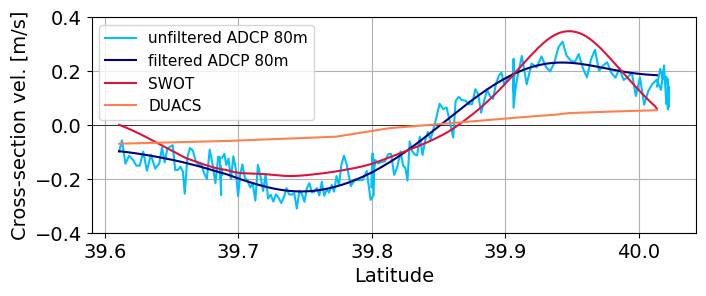

In [28]:
plt.figure(figsize=(7.8,2.8))

# add visible grid
plt.grid(visible=True)
#add line in 0
plt.axhline(0, color='black', lw=0.5)

plt.plot(lat_adcp,uv_cross_unfiltered, label='unfiltered ADCP '+str(dep)+'m', color='deepskyblue')
plt.plot(interpolated_lats, uv_cross, label='filtered ADCP '+str(dep)+'m', color='navy')          # Blue line
plt.plot(interpolated_lats, uv_SWOT_cross, 'r', label='SWOT', color='CRIMSON')  # Red line
plt.plot(interpolated_lats,uv_DUACS_cross,label='DUACS',c='coral')


plt.ylim([-0.4, 0.4])

plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Cross-section vel. [m/s]', fontsize=14)

plt.xticks(fontsize=14)  # X-axis tick font size
plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=14)  # Specify desired y-axis tick locations and font size

plt.legend(fontsize=11)  # Legend font size

#plt.tight_layout()

#plt.savefig('cross_vel_adcp_swot_v01_duacs_tr'+str(trans)+'depth'+str(dep)+'m_lat_Estret.png',dpi=1200)

#### COMPUTE THE RMSD

In [29]:
# COMPUTE RMSD AT EACH POINT BETWEEN ADCP AND SWOT
rmsd_s = np.sqrt((uv_cross - uv_SWOT_cross)**2)
len(rmsd_s)

190

In [30]:
rmsd_d = np.sqrt((uv_cross - uv_DUACS_cross)**2)

In [31]:
# save rmsd_s and rmsd_d in a pkl file
rmsd = pd.DataFrame({'rmsd_s':rmsd_s, 'rmsd_d':rmsd_d, 'lat':interpolated_lats, 'uv_cross_adcp':uv_cross, 'uv_SWOT_cross':uv_SWOT_cross, 'uv_DUACS_cross':uv_DUACS_cross})

rmsd.to_pickle('rmsd_cross_vels_tr'+str(trans)+'_dep'+str(dep)+'_filt15km.pkl')

In [32]:
# compute rmsd between ADCP and SWOT
rmsd = np.sqrt(np.mean((uv_cross - uv_DUACS_cross)**2))
rmsd*100

14.017983614897897

In [33]:
rmsd = np.sqrt(np.nanmean((uv_cross - uv_SWOT_cross)**2))
rmsd*100


5.643367461949005

In [34]:
# % IMPROVEMENT OF SWOT OVER DUACS
rmsd = np.sqrt(np.nanmean((uv_cross - uv_SWOT_cross)**2))
rmsd_DUACS = np.sqrt(np.nanmean((uv_cross - uv_DUACS_cross)**2))
improvement = (rmsd_DUACS - rmsd) / rmsd_DUACS
improvement*100

59.74194565364307

## PLOT 2: MAP


In [35]:
lonminz, lonmaxz, latminz, latmaxz = 1.4, 1.8,39.65,40

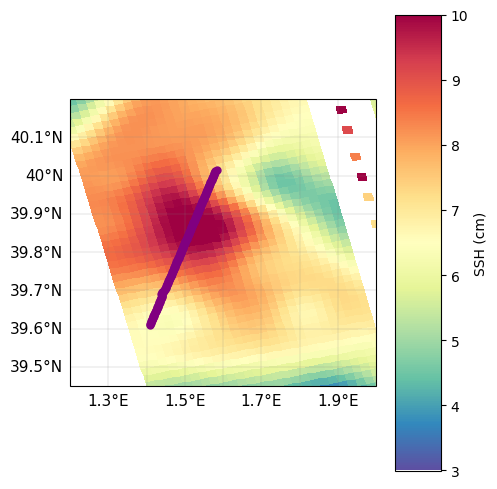

In [36]:
fig = plt.figure(figsize=(5,5))

gs  = gridspec.GridSpec(1, 1)
ax  = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())

# domain extent
ax.set_extent([lonminz-0.2, lonmaxz+0.2, latminz-0.2, latmaxz+0.2], ccrs.PlateCarree())

sc=plt.scatter(interpolated_lons,interpolated_lats,100,marker='.',c='purple',label = 'glider 01',zorder=10)

plot = plt.pcolormesh(ds_SWOT.longitude, ds_SWOT.latitude, ds_SWOT.ssha_noiseless*100, 
                               transform=ccrs.PlateCarree(), vmin=3,vmax=10, cmap='Spectral_r')

# add colorbar
cbar = plt.colorbar(plot, orientation='vertical', label='SSH (cm)', pad=0.05, aspect=10)

# Grid and ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='-',zorder=2)

gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 11}#, 'color': 'gray'}
gl.ylabel_style = {'size': 11}#, 'color': 'gray'}

plt.tight_layout()

## PLOT 3: CROSS-VELOCITIES TRANSECT

In [37]:
Depth  = ds.depth

Time = ds.time[ds['transect_id']==6].values

Lat = ds['lat'].where(ds['transect_id']==6, drop=True)
Lon = ds['lon'].where(ds['transect_id']==6, drop=True)
V = ds['v'].where(ds['transect_id']==6, drop=True)
U = ds['u'].where(ds['transect_id']==6, drop=True)

In [38]:
# Calculate the rotated complex number
uv_rotated_trans = (U + 1j*V) * cmath.exp(1j * (-angle) * cmath.pi / 180)

# Extract along- and cross-section values
#uv_along = uv_rotated.real
uv_cross_trans = np.array(uv_rotated_trans).imag

np.shape(uv_cross_trans)

(256, 40)

interpolar tota la secció


In [39]:
# Initialize the matrix to store interpolated values
new_uv_cross_trans = np.zeros((len(regular_distances), len(Depth.values)))

for i in range(len(Depth.values)):  # Loop over each depth layer
    # Interpolate the current depth layer
    f = interp1d(distances, uv_cross_trans[:, i], kind='linear', fill_value='extrapolate')
    
    interpolated_uv = f(regular_distances)
    
    # Handle potential NaNs after interpolation (optional)
    interpolated_uv = np.nan_to_num(interpolated_uv, nan=0.0)  # or choose another strategy
    
    # Apply low-pass filter to the interpolated values
    smoothed_uv = low_pass_filter(interpolated_uv, cutoff_distance, fs)
    
    # Optionally handle NaNs after smoothing (if applicable)
    smoothed_uv = np.nan_to_num(smoothed_uv, nan=0.0)  # or another value
    
    # Store the smoothed result
    new_uv_cross_trans[:, i] = smoothed_uv


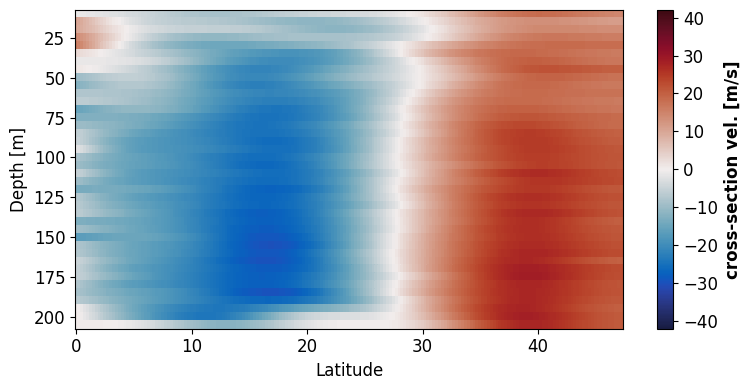

In [40]:
plt.figure(figsize=(7.8,4))
plt.pcolor(regular_distances,Depth.values,new_uv_cross_trans.T*100,cmap=cmocean.cm.balance,vmin=-42,vmax=42) # no interpolat ni suavitzat
# plt.contour(interpolated_lats,Depth,new_uv_cross_trans.T*100,vmin=-42,vmax=42, levels = 22) # interpolat i suavitzat

plt.gca().invert_yaxis()
plt.xlabel('Latitude',fontsize=12)

plt.ylabel('Depth [m]',fontsize=12)
#change ticks size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

cbar = plt.colorbar(label='cross-section vel. [m/s]')
#change colorbar ticks size
cbar.ax.tick_params(labelsize=12)
#change colorbar label size
cbar.ax.yaxis.label.set_size(12)
# and bold
cbar.ax.yaxis.label.set_weight('bold')

plt.tight_layout()
#plt.savefig('adcp_transect6_crossvel.png',dpi = 1200)

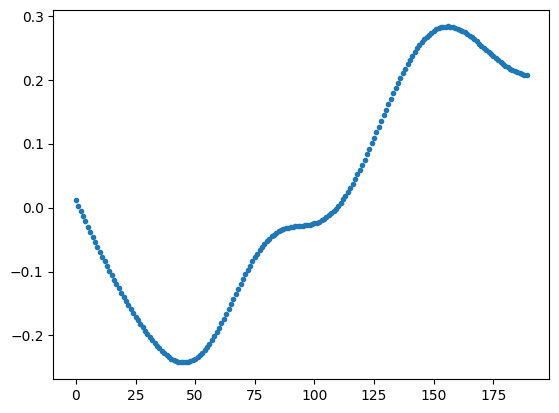

In [45]:
# find values at depth 200m
depth = 200
depth_index = np.where(Depth.values == depth)[0][0]
# find velocity at depth 200m
plt.plot(new_uv_cross_trans[:, depth_index],'.')

In [75]:
# Find the index of the maximum absolute velocity across all latitudes and depths
max_vel_idx = np.unravel_index(np.nanargmax(new_uv_cross_trans), new_uv_cross_trans.shape)

# Extract the corresponding depth
depth_max_velocity = Depth.values[max_vel_idx[1]]  # Index corresponds to depth dimension

# Extract the maximum velocity value
max_velocity = new_uv_cross_trans[max_vel_idx]

print(f"Maximum velocity: {max_velocity}")
print(f"Depth at maximum velocity: {depth_max_velocity}")


Maximum velocity: 0.2882033155070256
Depth at maximum velocity: 175


In [76]:
# Find the index of the maximum absolute velocity across all latitudes and depths
min_vel_idx = np.unravel_index(np.nanargmin(new_uv_cross_trans), new_uv_cross_trans.shape)

# Extract the corresponding depth
depth_min_velocity = Depth.values[min_vel_idx[1]]  # Index corresponds to depth dimension

# Extract the maximum velocity value
min_velocity = new_uv_cross_trans[min_vel_idx]

print(f"Minimum velocity: {min_velocity}")
print(f"Depth at minimum velocity: {depth_min_velocity}")

Minimum velocity: -0.2986770307761107
Depth at minimum velocity: 155


### COMPUTE RO


In [77]:
def compute_vorticity_2d(u_cross, y):
    """
    Compute vertical relative vorticity (ζ) in 2D using finite differences.
    
    Parameters:
    u_cross: 2D array (depth x section distance) of cross-section velocity (m/s)
    y: 1D array of distances along the section (m)

    Returns:
    zeta: 2D array (depth x section distance) of relative vorticity (s⁻¹)
    """
    zeta = -np.gradient(u_cross, y, axis=1)  # Compute -du/dy along the section
    return zeta

# Compute vorticity
zeta = compute_vorticity_2d(new_uv_cross_trans.T, regular_distances*1000)  # Section_Dist is the along-section distance


In [78]:
def compute_rossby_number_2d(zeta, latitude):
    """
    Compute the Rossby number Ro = ζ / f in 2D.
    
    Parameters:
    zeta: 2D array of relative vorticity (s⁻¹)
    latitude: Single latitude value (degrees)

    Returns:
    Ro: 2D array of Rossby number
    """
    omega = 7.2921e-5  # Earth's rotation rate (rad/s)
    f = 2 * omega * np.sin(np.radians(latitude))  # Compute Coriolis parameter

    if f == 0:
        f = np.nan  # Avoid division by zero at the equator

    Ro = zeta / f
    return Ro

# Compute Rossby number using a single latitude value
latitude = 30  # Replace with your actual latitude
Ro = compute_rossby_number_2d(zeta, latitude)


## DEF


/tmp/ipykernel_170651/4197374893.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(regular_distances, uv_SWOT_cross*100, 'r', linewidth = 2, label='SWOT', color='coral')  # Red line


Text(1.01, 0.95, '(d)')

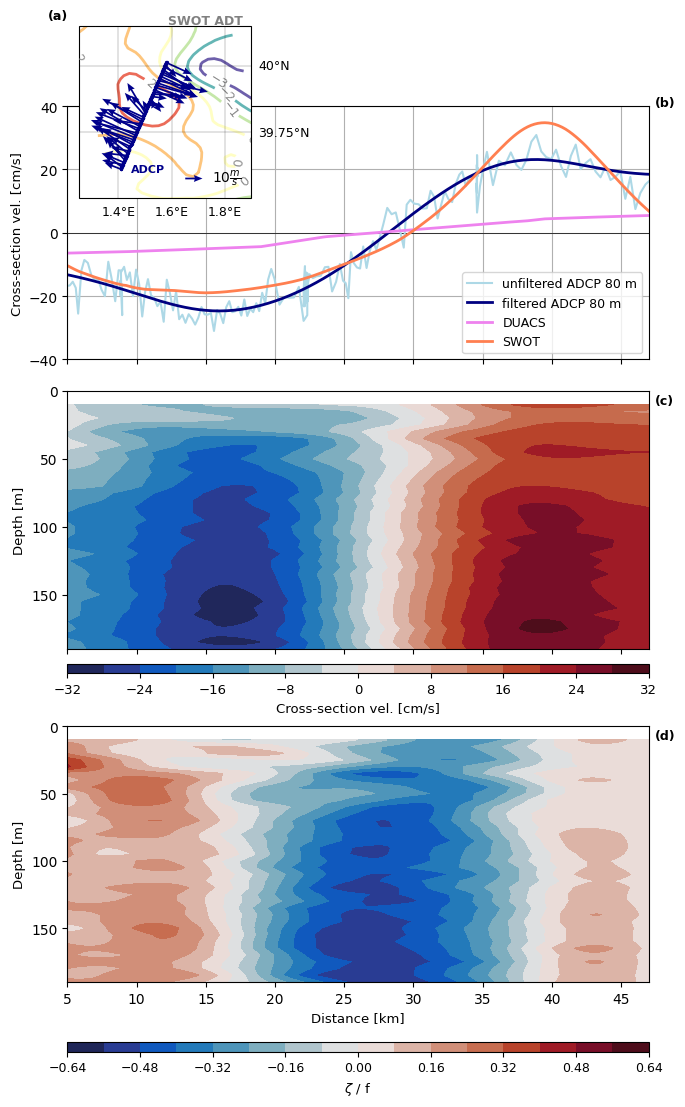

In [79]:
# Create the figure and main gridspec layout
fig = plt.figure(figsize=(7.5, 12))

# CREATE SUBPLOT OF TWO ROWS AND ONE COLUMN
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1.2, 1.2])

# FIRST SUBPLOT #############################################
ax1 = fig.add_subplot(gs[0, 0])

# add visible grid
ax1.grid(visible=True)
#add line in 0
ax1.axhline(0, color='black', lw=0.5)

ax1.plot(distances[:-21],uv_cross_unfiltered[:-21]*100,  label='unfiltered ADCP '+str(dep)+' m', color='lightblue')
ax1.plot(regular_distances, uv_cross*100, linewidth = 2,label='filtered ADCP '+str(dep)+' m', color='navy')          # Blue line
ax1.plot(regular_distances,uv_DUACS_cross*100,linewidth = 2, label='DUACS',c='violet')
ax1.plot(regular_distances, uv_SWOT_cross*100, 'r', linewidth = 2, label='SWOT', color='coral')  # Red line

# ax1.set_xlim([39.6075, 40.015])
ax1.set_xlim(5,47)
ax1.set_ylim([-40, 40])
ax1.set_ylabel('Cross-section vel. [cm/s]', fontsize=9.5)
ax1.legend(loc = 'lower right', fontsize=9)
ax1.locator_params(axis='y', nbins=5)
ax1.set_xticklabels([])

# SECOND SUBPLOT ############################################
ax2 = fig.add_subplot(gs[1, 0])
# pc2 = ax2.pcolormesh(Lat.values,Depth.values,uv_cross_trans.T*100,cmap=cmocean.cm.balance,vmin=-40,vmax=40)
pc2 = plt.contourf(regular_distances,Depth.values,new_uv_cross_trans.T*100,levels = 14, cmap=cmocean.cm.balance) # no interpolat ni suavitzat

ax2.invert_yaxis()

#ax2.grid(visible=True)
# ax2.set_xlabel('Distance [km]',fontsize=10)
# ax2.set_xlim([39.6075, 40.015])
ax2.set_ylabel('Depth [m]', fontsize=9.5)
ax2.locator_params(axis='y', nbins=5)

# no ticks in x axis
ax2.set_xticklabels([])

# set ylim
# ax2.set_ylim([0, 195])
ax2.set_ylim([190, 0])
ax2.set_xlim(5,47)

cbar = fig.colorbar(pc2, ax=ax2, label='Cross-section vel. [cm/s]', orientation='horizontal', aspect=60, pad = 0.001, anchor=(0.5, 0.6))
# change colorbar ticks size
cbar.ax.tick_params(labelsize=9.5)
# change colorbar label size
cbar.set_label(label='Cross-section vel. [cm/s]', size=9.5)

# THIRD SUBPLOT ############################################
ax3 = fig.add_subplot(gs[2, 0])

pc3 = ax3.contourf(regular_distances, Depth.values, Ro, levels = 14, cmap=cmocean.cm.balance)

ax3.invert_yaxis()

ax3.set_xlabel('Distance [km]',fontsize=9.5)
ax3.set_ylabel('Depth [m]', fontsize=9.5)
ax3.locator_params(axis='y', nbins=5)

ax3.set_ylim([190, 0])
ax3.set_xlim(5,47)

cbar3 = fig.colorbar(pc3, ax=ax3, label=r'$\zeta$ / f', orientation='horizontal', aspect=60, pad = 0.009, anchor=(0.5, -0.6))

# change colorbar ticks size
cbar3.ax.tick_params(labelsize=9)
# change colorbar label size
cbar3.ax.yaxis.label.set_size(9.5)
cbar3.set_label(label=r'$\zeta$ / f', size=9.5)


##################### MAPA ########################################
inset_ax = fig.add_axes([0.14, 0.76, 0.23, 0.23], projection=ccrs.PlateCarree())  # [left, bottom, width, height]
inset_ax.set_extent([1.25, 1.9, 39.5, 40.15], ccrs.PlateCarree())
#inset_ax.pcolormesh(ds_SWOT.longitude, ds_SWOT.latitude, ds_SWOT.ssha_noiseless*100, 
#                               transform=ccrs.PlateCarree(), vmin=3,vmax=10, cmap='Spectral_r')
CS=inset_ax.contour(ds_SWOT.longitude, ds_SWOT.latitude, (ds_SWOT.ssha_noiseless + ds_SWOT.mdt) * 100, 
                 cmap='Spectral_r', linewidths = 2, alpha = 0.9, vmin=-3,vmax=3, levels = 7, transform=ccrs.PlateCarree())

# Add labels to contours

inset_ax.clabel(CS, inline=True, fontsize=9, colors='gray')
#inset_ax.set_title('SWOT SSHA', fontsize=6)
# title inside plot
inset_ax.text(0.95, 1.07, 'SWOT ADT', transform=inset_ax.transAxes, fontsize=9, va='top', ha='right', color='gray', fontweight = 'bold')
inset_ax.text(0.5, 0.2, 'ADCP', color= 'darkblue', transform=inset_ax.transAxes, fontweight= 'bold',fontsize=8, va='top', ha='right')

q = inset_ax.quiver(interpolated_lons[::4],interpolated_lats[::4], interpolated_u[::4], interpolated_v[::4],  scale=1, zorder=10, 
                transform=ccrs.PlateCarree(), width=0.01, headwidth=4, color= 'darkblue')

inset_ax.scatter(interpolated_lons,interpolated_lats,8,marker='.',color='darkblue',zorder=10)

qk = plt.quiverkey(q, 0.305, 0.82, 0.1, r'$10 \frac{m}{s}$', labelpos='E', coordinates='figure',color='darkblue')

# add gridlines
gl = inset_ax.gridlines(draw_labels=True, linewidth=0.2, color='black', alpha=0.8, linestyle='-', zorder=10)

# change gl label size
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}
gl.top_labels = False
gl.left_labels = False


gl.ylocator = plt.MaxNLocator(3)  # Optional: adjust number of latitude lines
gl.xlocator = plt.MaxNLocator(4)  # Optional: adjust number of latitude lines

# Reduce space between subplots
plt.subplots_adjust(hspace=0.11)

# put a,b,c
plt.text(1.01, 1, '(b)', transform=ax1.transAxes, fontsize=9, fontweight='bold')
plt.text(1.01, 0.95, '(c)', transform=ax2.transAxes, fontsize=9, fontweight='bold')
plt.text(-0.18, 1.04, '(a)', transform=inset_ax.transAxes, fontsize=9, fontweight='bold')
plt.text(1.01, 0.95, '(d)', transform=ax3.transAxes, fontsize=9, fontweight='bold')


# plt.savefig('subplots_adcp_section6_vels_Ro_depth_80m_def_filter_15km_v3.png',dpi=600, bbox_inches='tight')